## Imports¶

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib widget
import numpy as np
import seaborn as sns
import tensorflow as tf
from IPython.display import clear_output
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import (
    optimizers, utils  # to choose more advanced optimizers like 'adam'
)
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
import pickle
from mpl_toolkits.mplot3d import Axes3D
import joblib

2026-01-28 15:08:23.188270: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  0


In [3]:
# run this if you want to force the not use of the GPU
tf.config.set_visible_devices([], "GPU")

In [4]:
def save_object(obj, filename):
    try:
        with open(filename, "wb") as f:
            pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    except Exception as ex:
        print("Error during pickling object (Possibly unsupported):", ex)


def load_object(filename):
    # 1. Prova con pickle
    try:
        with open(filename, "rb") as f:
            return pickle.load(f)
    except Exception as ex:
        print(f"Pickle load failed ({ex}), trying joblib...")

    # 2. Fallback con joblib
    try:
        return joblib.load(filename)
    except Exception as ex2:
        print(f"Joblib load also failed ({ex2}).")
        raise

## Loading of datas 

In [5]:
efficiency_CN, y_CN, eta_CN = load_object("4-LEVEL_Datas/data_CN.pkl")

efficiency_ACN, y_ACN, eta_ACN = load_object("4-LEVEL_Datas/data_ACN.pkl")

eff_UCN_list = []
y_UCN_list = []
σs_list = []

for i in range(13):
    eff_UCN, y_UCN, (σ1, σ2) = load_object(f"4-LEVEL_Datas/data_UCN_120trajs_part{i+1}.pkl")
    eff_UCN_list.append(eff_UCN)
    y_UCN_list.append(y_UCN)
    σs_list.append((σ1, σ2))

efficiency_UCN, y_UCN, (σ1, σ2) = np.vstack(eff_UCN_list), np.hstack(y_UCN_list), np.hstack(σs_list)


# efficiency_markovian, y_markovian, eta_M = load_object("../data/data_M.pkl")
_
efficiency_CM, y_CM, eta_CM, γ_CM = load_object(
    "4-LEVEL_Datas/data_CM.pkl"
)

efficiency_ACM, y_ACM, eta_ACM, γ_ACM  = (
    load_object("4-LEVEL_Datas/data_ACM.pkl")
)


efficiency_UCM, y_UCM, γs_UCM  = (
    load_object("4-LEVEL_Datas/data_UCM.pkl")
)


# Making of labeled dataset
# labeled data for non-Markovian (quasitatic) correlated noise
labeled_data1 = np.column_stack((efficiency_CN, y_CN))
# labeled data for non-Markovian (quasitatic) anti correlated noise
labeled_data2 = np.column_stack((efficiency_ACN, y_ACN))
# labeled data for non-Markovian (quasitatic) uncorrelated noise
labeled_data3 = np.column_stack((efficiency_UCN, y_UCN))
# labeled data for correlated, Markovian (non quasistatic) noise
labeled_data4 = np.column_stack(
    (efficiency_CM, y_CM)
)
# labeled data for anti-correlated, Markovian (non quasistatic) noise
labeled_data5 = np.column_stack(
    (efficiency_ACM, y_ACM)
)
# labeled data for uncorrelated, Markovian (non quasistatic) noise
labeled_data6 = np.column_stack(
    (efficiency_UCM, y_UCM)
)


data_6noises = [
    labeled_data1,
    labeled_data2,
    labeled_data3,
    labeled_data4,
    labeled_data5,
    labeled_data6
]

data_noises = data_6noises

Pickle load failed (invalid load key, '\x0e'.), trying joblib...
Pickle load failed (invalid load key, '\x0e'.), trying joblib...
Pickle load failed (invalid load key, '\x02'.), trying joblib...
Pickle load failed (invalid load key, '\x02'.), trying joblib...
Pickle load failed (invalid load key, '\x0e'.), trying joblib...
Pickle load failed (invalid load key, '\x0e'.), trying joblib...
Pickle load failed (invalid load key, '\x08'.), trying joblib...
Pickle load failed (invalid load key, '\x0d'.), trying joblib...
Pickle load failed (invalid load key, '\x0d'.), trying joblib...
Pickle load failed (invalid load key, '\x10'.), trying joblib...
Pickle load failed (invalid load key, '\x0e'.), trying joblib...
Pickle load failed (invalid load key, '\x0e'.), trying joblib...
Pickle load failed (invalid load key, '\x0e'.), trying joblib...


In [6]:
def make_balanced_data(data_list):
    
    X_test = []
    Y_test = []
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
    
    for data_ in data_list:
        X = np.array(data_[:, :-1])
        Y = np.array(data_[:, -1])  
    
        # Separate the test data
        x, x_test, y, y_test = train_test_split(X, Y, test_size=1/5)
    
        
        # Split the remaining data to train and validation
        x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=1/4)
    
        X_test += [x_test]
        Y_test += [y_test]
        X_val += [x_val]
        Y_val += [y_val]
        X_train += [x_train]
        Y_train += [y_train]
    
    # joined_data = [*labeled_data1, *labeled_data2, *labeled_data3, *labeled_data4]
    # x = tf.random.shuffle(joined_data, seed=112358, name=None)
    X_test = np.vstack(X_test)
    Y_test = np.hstack(Y_test)
    X_val = np.vstack(X_val)
    Y_val = np.hstack(Y_val)
    X_train = np.vstack(X_train)
    Y_train = np.hstack(Y_train)

    return X_test, Y_test, X_val, Y_val, X_train, Y_train

In [7]:
np.random.seed(1357)

X_test, Y_test, X_val, Y_val, X_train, Y_train = make_balanced_data(data_noises)

## Neural network and training

In [8]:
# Define network:
utils.set_random_seed(13579)

Net = Sequential()  # creating a neural network!

Net.add(
    Dense(64, input_shape=(3,), activation =  'relu'))
Net.add(Dense(32, activation = LeakyReLU(alpha=0.01)))  
Net.add(Dense(32, activation = LeakyReLU(alpha=0.01)))  
Net.add(Dense(32, activation = LeakyReLU(alpha=0.01)))
Net.add(Dense(len(data_noises), activation="softmax"))  # output layer: 5 neuron
print(Net.summary())

# Compile network: (randomly initialize weights, choose advanced optimizer, set up everything!)
Net.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=["accuracy"]
)  

model_MLP = Net

/home/shreyasi/miniforge3/envs/tf/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/shreyasi/miniforge3/envs/tf/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,646 (18.15 KB)

 Trainable params: 4,646 (18.15 KB)

 Non-trainable params: 0 (0.00 B)

None


In [9]:
# accuracy before training
train_loss0_MLP, train_acc0_MLP = model_MLP.evaluate(X_train, Y_train)
val_loss0_MLP, val_acc0_MLP = model_MLP.evaluate(X_val, Y_val)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0941 - loss: 1.7862      
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0993 - loss: 1.7865     


In [10]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5, restore_best_weights=True)

history_MLP = model_MLP.fit(X_train, Y_train, epochs=2000, validation_data = (X_val, Y_val), batch_size=40, callbacks=[stop_early])

Epoch 1/2000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2588 - loss: 1.7856 - val_accuracy: 0.3283 - val_loss: 1.7567
Epoch 2/2000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3829 - loss: 1.7280 - val_accuracy: 0.3983 - val_loss: 1.5738
Epoch 3/2000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4764 - loss: 1.5084 - val_accuracy: 0.4300 - val_loss: 1.3271
Epoch 4/2000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5088 - loss: 1.2961 - val_accuracy: 0.5117 - val_loss: 1.1707
Epoch 5/2000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5456 - loss: 1.1818 - val_accuracy: 0.5483 - val_loss: 1.1008
Epoch 6/2000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5778 - loss: 1.1143 - val_accuracy: 0.6083 - val_loss: 1.0384
Epoch 7/2000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6021 - loss: 1.0608 - val_accuracy: 0.6300 - val_loss: 1.0030
Epoch 8/2000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6252 - loss: 1.0229 - val_accuracy: 0.

In [11]:
# The model weights (that are considered the best) are loaded into the model.
Y_predict_MLP = model_MLP.evaluate(X_test, Y_test)
Y_predict_MLP

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9409 - loss: 0.1369 


[0.3312373757362366, 0.8633333444595337]

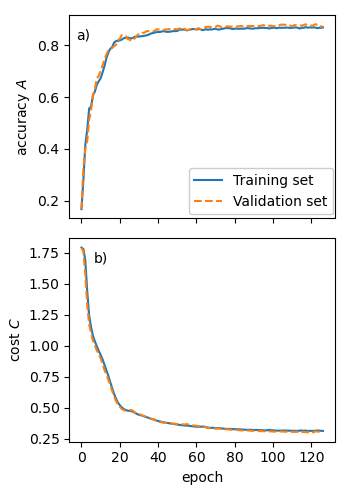

In [12]:
fig, ax = plt.subplots(2,1, figsize=(3.5, 5),  sharex=True)

ax[0].set_xticks(np.arange(len(history_MLP.history['accuracy'])+1,step=20))
ax[0].plot(np.arange(1+len(history_MLP.history['accuracy'])), [train_acc0_MLP] + history_MLP.history['accuracy'])
ax[0].plot(np.arange(1+len(history_MLP.history['val_accuracy'])), [val_acc0_MLP] + history_MLP.history['val_accuracy'], '--')
#ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy $A$')
#ax[0].set_xlabel('epoch')
ax[0].legend(['Training set', 'Validation set'], loc=(0.45,0.02), fontsize = "10", framealpha=1)
#ax[0].grid(True)

ax[1].set_xticks(np.arange(len(history_MLP.history['loss'])+1,step=20))
ax[1].plot(np.arange(1+len(history_MLP.history['loss'])), [train_loss0_MLP] + history_MLP.history['loss'])
ax[1].plot(np.arange(1+len(history_MLP.history['val_loss'])), [val_loss0_MLP] + history_MLP.history['val_loss'], '--')
#ax[1].set_title('model loss')
ax[1].set_ylabel(r'cost $C$')
ax[1].set_xlabel('epoch')
#ax[1].legend(['Training set', 'Validation set'], loc='upper right')
#ax[1].grid(True)

ax[0].text(0.05, 0.9, 'a)', horizontalalignment='center',
     verticalalignment='center', transform=ax[0].transAxes)
ax[1].text(0.12, 0.9, 'b)', horizontalalignment='center',
     verticalalignment='center', transform=ax[1].transAxes)


fig.tight_layout(w_pad=2)
#plt.savefig("figs/6_noise_training.png", dpi=600)


In [13]:
Y_pred = model_MLP.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)  # Converts predictions to class labels

# Compute the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred_classes)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


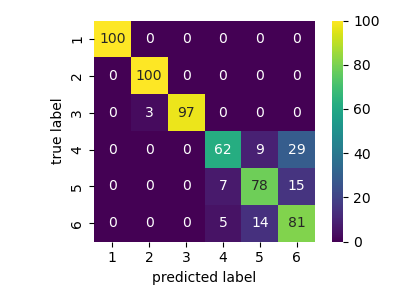

In [14]:
# Plotting the confusion matrix
ticklabels = ["1", "2", "3", "4", "5", "6"]
plt.figure(figsize=(4,3))
sns.heatmap(conf_matrix, annot=True, fmt='d', vmin=0, vmax=100, cmap="viridis", xticklabels=ticklabels, yticklabels=ticklabels, square=True)
plt.xlabel('predicted label')
plt.ylabel('true label')
#plt.title('Confusion Matrix')
plt.tight_layout()
#plt.savefig("figs/confusion_mat_6noise.png", dpi=600)

# Data analysis: efficiency plot for different pulse conditions (2D and 3D)

In [15]:
# class1 : efficiencies of correlated, non-Markovian noise
X1 = [np.array(efficiency_CN)[:,1], np.array(efficiency_CN)[:,2], np.array(efficiency_CN)[:,0]]

# class2 : efficiencies of anti-correlated, non-Markovian noise
X2 = [np.array(efficiency_ACN)[:,1], np.array(efficiency_ACN)[:,2], np.array(efficiency_ACN)[:,0]]

# class3 : efficiencies of uncorrelated, non-Markovian noise
X3 = [np.array(efficiency_UCN)[:,1], np.array(efficiency_UCN)[:,2], np.array(efficiency_UCN)[:,0]] 

# class4 : efficiencies of correlated, Markovian noise
X4 = [np.array(efficiency_CM)[:,1], np.array(efficiency_CM)[:,2], np.array(efficiency_CM)[:,0]] 

# class5 : efficiencies of anti-correlated, Markovian noise
X5 = [np.array(efficiency_ACM)[:,1], np.array(efficiency_ACM)[:,2], np.array(efficiency_ACM)[:,0]]

# class6 : efficiencies of uncorrelated, Markovian noise
X6 = [np.array(efficiency_UCM)[:,1], np.array(efficiency_UCM)[:,2], np.array(efficiency_UCM)[:,0]]

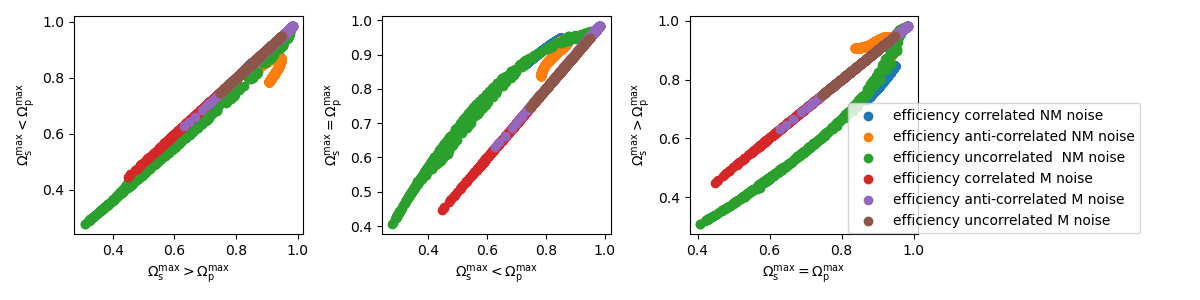

In [18]:
fig, ax = plt.subplots(1,3, figsize=[12,3])

combs = [(0,1), (1,2), (2,0)]
Label = ["efficiency correlated NM noise", "efficiency anti-correlated NM noise", 
         "efficiency uncorrelated  NM noise", "efficiency correlated M noise",  "efficiency anti-correlated M noise", "efficiency uncorrelated M noise"] 

for i in range(3):
    for X, lbl in zip([X1, X2, X3, X4, X5, X6], Label):
        ax[i].scatter(X[combs[i][0]], X[combs[i][1]], label =lbl)#, color = 'red', label =r"$Correlated, quasistatic noise$")
ax[0].set_xlabel(r"$\Omega_\mathrm{s}^{\mathrm{max}}>\Omega_\mathrm{p}^{\mathrm{max}}$")
ax[0].set_ylabel(r"$\Omega_\mathrm{s}^{\mathrm{max}}<\Omega_\mathrm{p}^{\mathrm{max}}$")
ax[1].set_xlabel(r"$\Omega_\mathrm{s}^{\mathrm{max}}<\Omega_\mathrm{p}^{\mathrm{max}}$")
ax[1].set_ylabel(r"$\Omega_\mathrm{s}^{\mathrm{max}}=\Omega_\mathrm{p}^{\mathrm{max}}$")
ax[2].set_xlabel(r"$\Omega_\mathrm{s}^{\mathrm{max}}=\Omega_\mathrm{p}^{\mathrm{max}}$")
ax[2].set_ylabel(r"$\Omega_\mathrm{s}^{\mathrm{max}}>\Omega_\mathrm{p}^{\mathrm{max}}$")
ax[2].legend()
ax[2].legend(loc="right", bbox_to_anchor=(2,0.3))
fig.tight_layout()

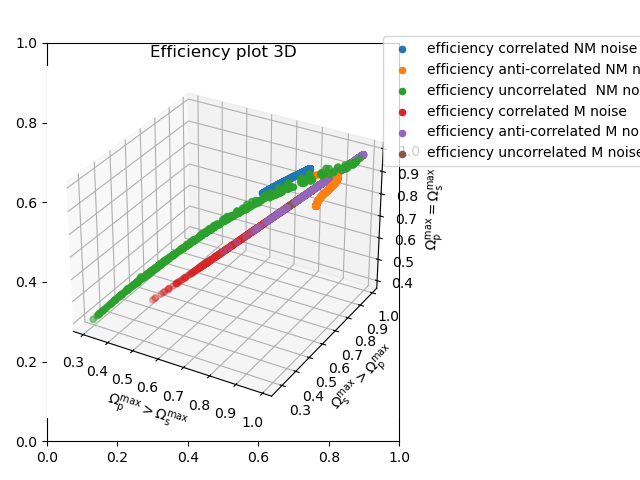

In [25]:
fig, ax = plt.subplots()
#ax = plt.axes(projection ="3d")
combs = [(0,1), (1,2), (2,0)]
Label = ["efficiency correlated NM noise", "efficiency anti-correlated NM noise", "efficiency uncorrelated  NM noise",
          "efficiency correlated M noise",  "efficiency anti-correlated M noise", "efficiency uncorrelated M noise" ] 


ax = plt.axes(projection ="3d")
for X, lbl in zip([X1, X2, X3, X4, X5, X6], Label):
    ax.scatter3D(X[0], X[1], X[2], label=lbl)

ax.set_title('Efficiency plot 3D')
ax.set_ylabel(r"$\Omega_\mathrm{s}^{\mathrm{max}}>\Omega_\mathrm{p}^{\mathrm{max}}$")
ax.set_xlabel(r"$\Omega_\mathrm{p}^{\mathrm{max}}>\Omega_\mathrm{s}^{\mathrm{max}}$")
ax.set_zlabel(r"$\Omega_\mathrm{p}^{\mathrm{max}}=\Omega_\mathrm{s}^{\mathrm{max}}$")
ax.legend()
ax.legend(loc="right", bbox_to_anchor=(1.8,0.9))
fig.tight_layout()